In [ ]:
import os
import torch
from torch import nn
from torch.nn import functional as F

In [ ]:
class FusedLeakyReLU(nn.Module):
    def __init__(self, channel, negative_slope=0.2, scale=2 ** 0.5):
        super().__init__()

        self.bias = nn.Parameter(torch.zeros(channel))
        self.negative_slope = negative_slope
        self.scale = scale

    def forward(self, input):
        return fused_leaky_relu(input, self.bias, self.negative_slope, self.scale)


def fused_leaky_relu(input, bias, negative_slope=0.2, scale=2 ** 0.5):
    rest_dim = [1] * (input.ndim - bias.ndim - 1)
    if input.ndim == 3:
        return (
            F.leaky_relu(
                input + bias.view(1, *rest_dim, bias.shape[0]), negative_slope=negative_slope
            )
            * scale
        )
    else:
        return (
            F.leaky_relu(
                input + bias.view(1, bias.shape[0], *rest_dim), negative_slope=negative_slope
            )
            * scale
        )

In [ ]:
def upfirdn2d(input, kernel, up=1, down=1, pad=(0, 0)):
    out = upfirdn2d_native(
        input, kernel, up, up, down, down, pad[0], pad[1], pad[0], pad[1]
    )

    return out


def upfirdn2d_native(
    input, kernel, up_x, up_y, down_x, down_y, pad_x0, pad_x1, pad_y0, pad_y1
):
    _, channel, in_h, in_w = input.shape
    input = input.reshape(-1, in_h, in_w, 1)

    _, in_h, in_w, minor = input.shape
    kernel_h, kernel_w = kernel.shape

    out = input.view(-1, in_h, 1, in_w, 1, minor)
    out = F.pad(out, [0, 0, 0, up_x - 1, 0, 0, 0, up_y - 1])
    out = out.view(-1, in_h * up_y, in_w * up_x, minor)

    out = F.pad(
        out, [0, 0, max(pad_x0, 0), max(pad_x1, 0), max(pad_y0, 0), max(pad_y1, 0)]
    )
    out = out[
        :,
        max(-pad_y0, 0) : out.shape[1] - max(-pad_y1, 0),
        max(-pad_x0, 0) : out.shape[2] - max(-pad_x1, 0),
        :,
    ]

    out = out.permute(0, 3, 1, 2)
    out = out.reshape(
        [-1, 1, in_h * up_y + pad_y0 + pad_y1, in_w * up_x + pad_x0 + pad_x1]
    )
    w = torch.flip(kernel, [0, 1]).view(1, 1, kernel_h, kernel_w)
    out = F.conv2d(out, w)
    out = out.reshape(
        -1,
        minor,
        in_h * up_y + pad_y0 + pad_y1 - kernel_h + 1,
        in_w * up_x + pad_x0 + pad_x1 - kernel_w + 1,
    )
    out = out.permute(0, 2, 3, 1)
    out = out[:, ::down_y, ::down_x, :]

    out_h = (in_h * up_y + pad_y0 + pad_y1 - kernel_h) // down_y + 1
    out_w = (in_w * up_x + pad_x0 + pad_x1 - kernel_w) // down_x + 1

    return out.view(-1, channel, out_h, out_w)

In [ ]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)

class To4d(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input.view(*input.size(),1,1)

def make_kernel(k):
    k = torch.tensor(k, dtype=torch.float32)

    if k.ndim == 1:
        k = k[None, :] * k[:, None]

    k /= k.sum()

    return k


class Upsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel) * (factor ** 2)
        self.register_buffer('kernel', kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2 + factor - 1
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=self.factor, down=1, pad=self.pad)

        return out


class Downsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel)
        self.register_buffer('kernel', kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=1, down=self.factor, pad=self.pad)

        return out


class Blur(nn.Module):
    def __init__(self, kernel, pad, upsample_factor=1):
        super().__init__()

        kernel = make_kernel(kernel)

        if upsample_factor > 1:
            kernel = kernel * (upsample_factor ** 2)

        self.register_buffer('kernel', kernel)

        self.pad = pad

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, pad=self.pad)

        return out


class EqualConv2d(nn.Module):
    def __init__(
        self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True
    ):
        super().__init__()

        self.weight = nn.Parameter(
            torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        )
        self.scale = 1 / math.sqrt(in_channel * kernel_size ** 2)

        self.stride = stride
        self.padding = padding

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channel))

        else:
            self.bias = None

    def forward(self, input):
        out = F.conv2d(
            input,
            self.weight * self.scale,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
        )

        return out

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]},'
            f' {self.weight.shape[2]}, stride={self.stride}, padding={self.padding})'
        )


class EqualLinear(nn.Module):
    def __init__(
        self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))

        else:
            self.bias = None

        self.activation = activation

        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)

        else:
            out = F.linear(
                input, self.weight * self.scale, bias=self.bias * self.lr_mul
            )

        return out

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})'
        )


class ScaledLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.2):
        super().__init__()

        self.negative_slope = negative_slope

    def forward(self, input):
        out = F.leaky_relu(input, negative_slope=self.negative_slope)

        return out * math.sqrt(2)


class ModulatedConv2d(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        demodulate=True,
        upsample=False,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
    ):
        super().__init__()

        self.eps = 1e-8
        self.kernel_size = kernel_size
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.upsample = upsample
        self.downsample = downsample

        if upsample:
            factor = 2
            p = (len(blur_kernel) - factor) - (kernel_size - 1)
            pad0 = (p + 1) // 2 + factor - 1
            pad1 = p // 2 + 1

            self.blur = Blur(blur_kernel, pad=(pad0, pad1), upsample_factor=factor)

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            self.blur = Blur(blur_kernel, pad=(pad0, pad1))

        fan_in = in_channel * kernel_size ** 2
        self.scale = 1 / math.sqrt(fan_in)
        self.padding = kernel_size // 2

        self.weight = nn.Parameter(
            torch.randn(1, out_channel, in_channel, kernel_size, kernel_size)
        )

        self.modulation = EqualLinear(style_dim, in_channel, bias_init=1)

        self.demodulate = demodulate

    def __repr__(self):
        return (
            f'{self.__class__.__name__}({self.in_channel}, {self.out_channel}, {self.kernel_size}, '
            f'upsample={self.upsample}, downsample={self.downsample})'
        )
    def get_latent(self, style):
        style = self.modulation(style)
        return style

    def forward(self, input, style):
        batch, in_channel, height, width = input.shape

        #style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
        style = style.view(batch, 1, in_channel, 1, 1)
        weight = self.scale * self.weight * style

        if self.demodulate:
            demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
            weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

        weight = weight.view(
            batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size
        )

        if self.upsample:
            input = input.view(1, batch * in_channel, height, width)
            weight = weight.view(
                batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size
            )
            weight = weight.transpose(1, 2).reshape(
                batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size
            )
            out = F.conv_transpose2d(input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)
            out = self.blur(out)

        elif self.downsample:
            input = self.blur(input)
            _, _, height, width = input.shape
            input = input.view(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=0, stride=2, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        else:
            input = input.view(1, batch * in_channel, height, width)
            out = F.conv2d(input, weight, padding=self.padding, groups=batch)
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        return out


class NoiseInjection(nn.Module):
    def __init__(self):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, image, noise=None):
        device = image.device
        if noise is None:
            batch, _, height, width = image.shape
            noise = image.new_empty(batch, 1, height, width).normal_()

        try:
            output = image + self.weight * noise
        except:
            # reproducible noise when differeing spatial
            old_width = noise.size(3)
            batch, _, height, width = image.shape
            gen = torch.Generator()
            gen = gen.manual_seed(width)
            #noise = torch.randn(*image.shape, generator=gen).cuda()
            out_noise = torch.zeros([batch,1,height,width]).normal_(generator=gen).to(device)
            out_noise[..., :old_width] = noise
            out_noise[..., -old_width:] = noise
            #noise = image.new_empty(batch, 1, height, width).normal_(generator=gen)
            output = image + self.weight * out_noise
        return output

    #def forward(self, image, noise=None):
    #    if noise is None:
    #        batch, _, height, width = image.shape
    #        noise = image.new_empty(batch, 1, height, width).normal_()

    #    output = image + self.weight * noise
    #    return output

class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out


class StyledConv(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        upsample=False,
        blur_kernel=[1, 3, 3, 1],
        demodulate=True,
    ):
        super().__init__()

        self.conv = ModulatedConv2d(
            in_channel,
            out_channel,
            kernel_size,
            style_dim,
            upsample=upsample,
            blur_kernel=blur_kernel,
            demodulate=demodulate,
        )

        self.noise = NoiseInjection()
        # self.bias = nn.Parameter(torch.zeros(1, out_channel, 1, 1))
        # self.activate = ScaledLeakyReLU(0.2)
        self.activate = FusedLeakyReLU(out_channel)

    def get_latent(self, style):
        return self.conv.get_latent(style)
    def forward(self, input, style, noise=None):
        out_t = self.conv(input, style)
        out = self.noise(out_t, noise=noise)
        # out = out + self.bias
        out = self.activate(out)

        return out, out_t


class ToRGB(nn.Module):
    def __init__(self, in_channel, style_dim, upsample=True, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        if upsample:
            self.upsample = Upsample(blur_kernel)

        self.conv = ModulatedConv2d(in_channel, 3, 1, style_dim, demodulate=False)
        self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

    def get_latent(self, style):
        return self.conv.get_latent(style)
    def forward(self, input, style, skip=None):
        out = self.conv(input, style)
        out = out + self.bias

        if skip is not None:
            skip = self.upsample(skip)

            out = out + skip

        return out

In [ ]:
class Generator(nn.Module):
    def __init__(
        self,
        size,
        style_dim,
        n_mlp,
        channel_multiplier=2,
        blur_kernel=[1, 3, 3, 1],
        lr_mlp=0.01,
    ):
        super().__init__()

        self.size = size

        self.style_dim = style_dim

        layers = [PixelNorm()]

        for i in range(n_mlp):
            layers.append(
                EqualLinear(
                    style_dim, style_dim, lr_mul=lr_mlp, activation='fused_lrelu'
                )
            )

        self.style = nn.Sequential(*layers)

        self.channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        self.input = ConstantInput(self.channels[4])
        self.conv1 = StyledConv(
            self.channels[4], self.channels[4], 3, style_dim, blur_kernel=blur_kernel
        )
        self.to_rgb1 = ToRGB(self.channels[4], style_dim, upsample=False)

        self.log_size = int(math.log(size, 2))
        self.num_layers = (self.log_size - 2) * 2 + 1

        self.convs = nn.ModuleList()
        self.upsamples = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()
        self.noises = nn.Module()

        in_channel = self.channels[4]

        for layer_idx in range(self.num_layers):
            res = (layer_idx + 5) // 2
            shape = [1, 1, 2 ** res, 2 ** res]
            self.noises.register_buffer(f'noise_{layer_idx}', torch.randn(*shape))

        for i in range(3, self.log_size + 1):
            out_channel = self.channels[2 ** i]

            self.convs.append(
                StyledConv(
                    in_channel,
                    out_channel,
                    3,
                    style_dim,
                    upsample=True,
                    blur_kernel=blur_kernel,
                )
            )

            self.convs.append(
                StyledConv(
                    out_channel, out_channel, 3, style_dim, blur_kernel=blur_kernel
                )
            )

            self.to_rgbs.append(ToRGB(out_channel, style_dim))

            in_channel = out_channel

        self.n_latent = self.log_size * 2 - 2

    def make_noise(self):
        device = self.input.input.device

        noises = [torch.randn(1, 1, 2 ** 2, 2 ** 2, device=device)]

        for i in range(3, self.log_size + 1):
            for _ in range(2):
                noises.append(torch.randn(1, 1, 2 ** i, 2 ** i, device=device))

        return noises

    def mean_latent(self, n_latent):
        latent_in = torch.randn( n_latent, self.style_dim, device=self.input.input.device)
        latent = self.get_latent(latent_in)#.mean(0, keepdim=True)
        latent = [latent[i].mean(0, keepdim=True) for i in range(len(latent))]

        return latent

    def get_w(self, input):
        device = self.input.input.device
        latent = self.style(input)
        latent = fused_leaky_relu(latent, torch.zeros_like(latent).to(device), 5.)
        return latent

    def get_latent(self, input, is_latent=False, truncation=1, mean_latent=None):
        output = []
        if not is_latent:
            latent = self.style(input)
            latent = latent.unsqueeze(1).repeat(1, self.n_latent, 1) #[B, 14, 512]
        else:
            latent = input
        output.append(self.conv1.get_latent(latent[:, 0]))
        output.append(self.to_rgb1.get_latent(latent[:, 1]))

        i = 1
        for conv1, conv2, to_rgb in zip(self.convs[::2], self.convs[1::2], self.to_rgbs):
            output.append(conv1.get_latent(latent[:, i]))
            output.append(conv2.get_latent(latent[:, i+1]))
            output.append(to_rgb.get_latent(latent[:, i+2]))
            i += 2

        if truncation < 1 and mean_latent is not None:
            output = [mean_latent[i] + truncation * (output[i] - mean_latent[i]) for i in range(len(output))]
            
        return output

    def patch_swap(self, latent1, latent2, coord, swap=True):
        noise = [getattr(self.noises, f'noise_{i}') for i in range(self.num_layers)]

        coord = torch.tensor(coord).long()
        # this is the case of single image patch swap.
        if coord.ndim == 3:
            coord = coord[0]
        
        out = self.input(latent1[0])

        out1, _ = self.conv1(out, latent1[0], noise=noise[0])
        out2, _ = self.conv1(out, latent2[0], noise=noise[0])

        skip1 = self.to_rgb1(out1, latent1[1])
        skip2 = self.to_rgb1(out2, latent2[1])

        i = 2
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):

            out1, _ = conv1(out1, latent1[i], noise=noise1)
            out2, _ = conv1(out2, latent2[i], noise=noise1)

            out1, _ = conv2(out1, latent1[i+1], noise=noise2)
            out2, _ = conv2(out2, latent2[i+1], noise=noise2)

            skip1 = to_rgb(out1, latent1[i+2], skip1)
            skip2 = to_rgb(out2, latent2[i+2], skip2)

            # 2 for more blending less texture accuracy, 5 for more exact transfer
            if i == 5:
            #if i < 20:
            #if i == 2:
                h,w = out1.size()[2:]
                scale = 256 // h
                scaled_coord = torch.floor(coord / scale).long()
                x1, y1, w1, h1 = scaled_coord[0]
                x2, y2, w2, h2 = scaled_coord[1]

                w = max(w1,w2)
                h = max(h1,h2)

                out1[:,:,y1:y1+h,x1:x1+w] = out2[:,:,y2:y2+h,x2:x2+w]
                if swap:
                    out1[:,:,y2:y2+h,x2:x2+w] = out2[:,:,y1:y1+h,x1:x1+w]

            i += 3

        image = skip1.clamp(-1,1)
        return image

    def singan(self, latent, mode):
        noise = [None] * self.num_layers
#         noise = [getattr(self.noises, f'noise_{i}') for i in range(self.num_layers)]
        
        out = self.input(latent[0])        
        out, _ = self.conv1(out, latent[0], noise=noise[0])
        skip = self.to_rgb1(out, latent[1])


        i = 2
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):

            out, _ = conv1(out, latent[i], noise=noise1)
            out, _ = conv2(out, latent[i+1], noise=noise2)
            skip = to_rgb(out, latent[i+2], skip)
            
            if i == 2:
                h,w = out.size()[2:]
                if mode == 'horizontal': 
                    out_h = h
                    out_w = w*2
                    out = F.interpolate(out, size=(out_h, out_w), mode='nearest')
                    skip = F.interpolate(skip, size=(out_h, out_w), mode='nearest')

                elif mode == 'vertical':
                    out_h = h*2
                    out_w = w
                    out = F.interpolate(out, size=(out_h, out_w), mode='nearest')
                    skip = F.interpolate(skip, size=(out_h, out_w), mode='nearest')
                else:
                    pad_type = mode
                    npad = w // 2
                    out = F.pad(out, (npad,npad,0,0), pad_type)
                    skip = F.pad(skip, (npad,npad,0,0), pad_type)

                    #out = torch.roll(out, npad, 3)
                    #skip = torch.roll(skip, npad, 3)
            i += 3

        image = skip.clamp(-1,1)
        return image



    def blend_bbox(self, latent1, latent2, coord, model_type, num_blend=99):
        noise = [getattr(self.noises, f'noise_{i}') for i in range(self.num_layers)]

        if model_type == 'face':
            pose_align = True
            pose_num = 4
        else:
            pose_align = False

        x, y, w, h = coord[0]

        device = self.input.input.device
        mask = torch.zeros([1,1,256,256]).to(device)
        mask[..., y:y+h, x:x+w] = 1
        k_h = h//2
        k_h += k_h%2+1
        k_h = int(k_h)
        k_w = w//2
        k_w += k_w%2+1
        k_w = int(k_w)

        mask = k.gaussian_blur2d(mask, (k_h, k_w), sigma=(k_h, k_w))
        #mask = k.gaussian_blur2d(mask, (53,125), sigma=(53,125))
        
        out = self.input(latent1[0])
        
        out1, _ = self.conv1(out, latent1[0], noise=noise[0])
        out2, _ = self.conv1(out, latent2[0], noise=noise[0])
        alpha = F.interpolate(mask, size=out1.size()[2:], mode='bilinear')
        out = (1-alpha)*out1 + alpha*out2

        skip1 = self.to_rgb1(out, latent1[1])
        skip2 = self.to_rgb1(out, latent2[1])
        alpha = F.interpolate(mask, size=skip1.size()[2:], mode='bilinear')
        if pose_align: alpha.zero_()
        skip = (1-alpha)*skip1 + alpha*skip2


        i = 2
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):

            out1, _ = conv1(out, latent1[i], noise=noise1)
            out2, _ = conv1(out, latent2[i], noise=noise1)
            alpha = F.interpolate(mask, size=out1.size()[2:], mode='bilinear')
            if i > num_blend or (pose_align and i < pose_num): alpha.zero_()
            out = (1-alpha)*out1 + alpha*out2
            i += 1

            out1, _ = conv2(out, latent1[i], noise=noise2)
            out2, _ = conv2(out, latent2[i], noise=noise2)
            alpha = F.interpolate(mask, size=out1.size()[2:], mode='bilinear')
            if i > num_blend or (pose_align and i < pose_num): alpha.zero_()
            out = (1-alpha)*out1 + alpha*out2
            i += 1

            skip1 = to_rgb(out, latent1[i], skip)
            skip2 = to_rgb(out, latent2[i], skip)
            alpha = F.interpolate(mask, size=skip1.size()[2:], mode='bilinear')
            if i > num_blend or (pose_align and i < pose_num): alpha.zero_()
            skip = (1-alpha)*skip1 + alpha*skip2
            i += 1

        image = skip.clamp(-1,1)
        return image
    
    def blend(self, latent1, latent2, mode):
        noise = [getattr(self.noises, f'noise_{i}') for i in range(self.num_layers)]
        device = self.input.input.device

        assert mode in ('vertical', 'horizontal')
        if mode == 'vertical':
            view_size = (1,1,-1,1)
        else:
            view_size = (1,1,1,-1)
            
        out = self.input(latent1[0])
        
        out1, _ = self.conv1(out, latent1[0], noise=noise[0])
        out2, _ = self.conv1(out, latent2[0], noise=noise[0])
        alpha = torch.zeros([out1.size(2)])
        pad = out1.size(2)//4
        alpha[-pad:] = 1
        alpha[pad:-pad] = torch.linspace(0,1,alpha.size(0)-2*pad)
        alpha = alpha.view(*view_size).expand_as(out1).to(device)
        out = (1-alpha)*out1 + alpha*out2

        skip1 = self.to_rgb1(out, latent1[1])
        skip2 = self.to_rgb1(out, latent2[1])
        alpha = torch.zeros([skip1.size(2)])
        pad = skip1.size(2)//4
        alpha[-pad:] = 1
        alpha[pad:-pad] = torch.linspace(0,1,alpha.size(0)-2*pad)
        alpha = alpha.view(*view_size).expand_as(skip1).to(device)
        skip = (1-alpha)*skip1 + alpha*skip2


        i = 2
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):

            out1, _ = conv1(out, latent1[i], noise=noise1)
            out2, _ = conv1(out, latent2[i], noise=noise1)
            alpha = torch.zeros([out1.size(2)])
            pad = out1.size(2)//4
            alpha[-pad:] = 1
            alpha[pad:-pad] = torch.linspace(0,1,alpha.size(0)-2*pad)
            alpha = alpha.view(*view_size).expand_as(out1).to(device)
            out = (1-alpha)*out1 + alpha*out2

            out1, _ = conv2(out, latent1[i+1], noise=noise2)
            out2, _ = conv2(out, latent2[i+1], noise=noise2)
            alpha = torch.zeros([out1.size(2)])
            pad = out1.size(2)//4
            alpha[-pad:] = 1
            alpha[pad:-pad] = torch.linspace(0,1,alpha.size(0)-2*pad)
            alpha = alpha.view(*view_size).expand_as(out1).to(device)
            out = (1-alpha)*out1 + alpha*out2

            skip1 = to_rgb(out, latent1[i+2], skip)
            skip2 = to_rgb(out, latent2[i+2], skip)
            alpha = torch.zeros([skip1.size(2)])
            pad = skip1.size(2)//4
            alpha[-pad:] = 1
            alpha[pad:-pad] = torch.linspace(0,1,alpha.size(0)-2*pad)
            alpha = alpha.view(*view_size).expand_as(skip1).to(device)
            skip = (1-alpha)*skip1 + alpha*skip2

            i += 3

        image = skip.clamp(-1,1)
        return image
    
    
    def merge_extension(self, latent1, latent2):
        noise = [getattr(self.noises, f'noise_{i}') for i in range(self.num_layers)]
        device = self.input.input.device
        
        out = self.input(latent1[0])
        out1, _ = self.conv1(out, latent1[0], noise=noise[0])
        out2, _ = self.conv1(out, latent2[0], noise=noise[0])
        out = torch.cat([out1, out2], 3)

        skip1 = self.to_rgb1(out, latent1[1])
        skip2 = self.to_rgb1(out, latent2[1])

        alpha = torch.zeros([skip1.size(3)])
        pad = skip1.size(3)//4
        alpha[-pad:] = 1
        alpha[pad:-pad] = torch.linspace(0,1,alpha.size(0)-2*pad)
        alpha = alpha.view(1,1,1,-1).expand_as(skip1).to(device)
        skip = (1-alpha)*skip1 + alpha*skip2


        i = 2
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):


            out1, _ = conv1(out, latent1[i], noise=noise1)
            out2, _ = conv1(out, latent2[i], noise=noise1)
            alpha = torch.zeros([out1.size(3)])
            pad = out1.size(3)//4
            alpha[-pad:] = 1
            alpha[pad:-pad] = torch.linspace(0,1,alpha.size(0)-2*pad)
            alpha = alpha.view(1,1,1,-1).expand_as(out1).to(device)
            out = (1-alpha)*out1 + alpha*out2

            out1, _ = conv2(out, latent1[i+1], noise=noise2)
            out2, _ = conv2(out, latent2[i+1], noise=noise2)
            alpha = torch.zeros([out1.size(3)])
            pad = out1.size(3)//4
            alpha[-pad:] = 1
            alpha[pad:-pad] = torch.linspace(0,1,alpha.size(0)-2*pad)
            alpha = alpha.view(1,1,1,-1).expand_as(out1).to(device)
            out = (1-alpha)*out1 + alpha*out2

            skip1 = to_rgb(out, latent1[i+2], skip)
            skip2 = to_rgb(out, latent2[i+2], skip)
            alpha = torch.zeros([skip1.size(3)])
            pad = skip1.size(3)//4
            alpha[-pad:] = 1
            alpha[pad:-pad] = torch.linspace(0,1,alpha.size(0)-2*pad)
            alpha = alpha.view(1,1,1,-1).expand_as(skip1).to(device)
            skip = (1-alpha)*skip1 + alpha*skip2

            i += 3

        image = skip.clamp(-1,1)
        return image

    def merge(self, latent1, latent2):
        noise = [getattr(self.noises, f'noise_{i}') for i in range(self.num_layers)]
        device = self.input.input.device
        
        out = self.input(latent1[0])
        out1, _ = self.conv1(out, latent1[0], noise=noise[0])
        out2, _ = self.conv1(out, latent2[0], noise=noise[0])
        out = torch.cat([out1, out2], 3)

        skip1 = self.to_rgb1(out, latent1[1])
        skip2 = self.to_rgb1(out, latent2[1])
        alpha = torch.linspace(0,1, skip1.size(3)).view(1,1,1,-1).expand_as(skip1).to(device)
        skip = (1-alpha)*skip1 + alpha*skip2


        i = 2
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):


            out1, _ = conv1(out, latent1[i], noise=noise1)
            out2, _ = conv1(out, latent2[i], noise=noise1)
            alpha = torch.linspace(0,1, out1.size(3)).view(1,1,1,-1).expand_as(out1).to(device)
            out = (1-alpha)*out1 + alpha*out2

            out1, _ = conv2(out, latent1[i+1], noise=noise2)
            out2, _ = conv2(out, latent2[i+1], noise=noise2)
            alpha = torch.linspace(0,1, out1.size(3)).view(1,1,1,-1).expand_as(out1).to(device)
            out = (1-alpha)*out1 + alpha*out2

            skip1 = to_rgb(out, latent1[i+2], skip)
            skip2 = to_rgb(out, latent2[i+2], skip)
            alpha = torch.linspace(0,1, skip1.size(3)).view(1,1,1,-1).expand_as(skip1).to(device)
            skip = (1-alpha)*skip1 + alpha*skip2

            i += 3

        image = skip.clamp(-1,1)
        return image
    
    def forward(
        self,
        styles,
        stop_idx=99,
        is_cluster=False,
        noise=None,
        randomize_noise=False,
    ):

        if noise is None:
            if randomize_noise:
                noise = [None] * self.num_layers
            else:
                noise = [
                    getattr(self.noises, f'noise_{i}') for i in range(self.num_layers)
                ]
                
        outputs = []
        idx_count = 0
        
        latent = styles
        out = self.input(latent[0])
        outputs.append([out, out])
        if idx_count == stop_idx:
            return outputs
        
        out, out_t = self.conv1(out, latent[idx_count], noise=noise[0])
        outputs.append([out_t, out])
        idx_count += 1
        if idx_count == stop_idx:
            return outputs

        skip = self.to_rgb1(out, latent[idx_count])

        i = 1
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):
            outputs.append([out_t, out])
            idx_count += 1
            if idx_count == stop_idx:
                return outputs

            out, out_t = conv1(out, latent[idx_count], noise=noise1)
            outputs.append([out_t, out])
            idx_count += 1
            if idx_count == stop_idx:
                return outputs

            out, out_t = conv2(out, latent[idx_count], noise=noise2)
            outputs.append([out_t, out])
            idx_count += 1
            if idx_count == stop_idx:
                return outputs

            skip = to_rgb(out, latent[idx_count], skip)

            i += 2

        image = skip.clamp(-1,1)
        return image, outputs

In [ ]:
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
import os
import cv2
from PIL import Image
import numpy as np
import math
import scipy
import scipy.ndimage
import torchvision

# Number of style channels per StyleGAN layer
style2list_len = [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 
                  512, 512, 512, 512, 512, 256, 256, 256, 128, 128]
# for 1024 x 1024
#style2list_len = [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 
#                  512, 512, 512, 512, 512, 256, 256, 256, 128, 128, 
#                  128, 64, 64, 64, 32, 32]

# Layer indices of ToRGB modules
rgb_layer_idx = [1,4,7,10,13,16,19,22,25]

google_drive_paths = {
    "church.pt": "https://drive.google.com/uc?id=1ORsZHZEeFNEX9HtqRutt1jMgrf5Gpcat",
    "face.pt": "https://drive.google.com/uc?id=1dOBo4xWUwM7-BwHWZgp-kV1upaD6tHAh",
    "landscape.pt": "https://drive.google.com/uc?id=1rN5EhwiY95BBNPvOezhX4SZ_tEOR0qe2",
    "disney.pt": "https://drive.google.com/uc?id=1n2uQ5s2XdUBGIcZA9Uabz1mkjVvKWFeG",
}

@torch.no_grad()
def load_model(generator, model_file_path):
    ensure_checkpoint_exists(model_file_path)
    ckpt = torch.load(model_file_path, map_location=lambda storage, loc: storage)
    generator.load_state_dict(ckpt["g_ema"], strict=False)
    return generator.mean_latent(50000)

def ensure_checkpoint_exists(model_weights_filename):
    if not os.path.isfile(model_weights_filename) and (
        model_weights_filename in google_drive_paths
    ):
        gdrive_url = google_drive_paths[model_weights_filename]
        try:
            from gdown import download as drive_download

            drive_download(gdrive_url, model_weights_filename, quiet=False)
        except ModuleNotFoundError:
            print(
                "gdown module not found.",
                "pip3 install gdown or, manually download the checkpoint file:",
                gdrive_url
            )

    if not os.path.isfile(model_weights_filename) and (
        model_weights_filename not in google_drive_paths
    ):
        print(
            model_weights_filename,
            " not found, you may need to manually download the model weights."
        )

# given a list of filenames, load the inverted style code
@torch.no_grad()
def load_source(files, generator, device): #원래는 device='cuda'였음
    sources = []
    
    for file in files:
        source = torch.load('/content/drive/Mydrive/cartoon/{file}.pt')['latent'].to(device)
        #원래 코드: source = torch.load(f'./inversion_codes/{file}.pt')['latent'].to(device)

        if source.size(0) != 1:
            source = source.unsqueeze(0)

        if source.ndim == 3:
            source = generator.get_latent(source, truncation=1, is_latent=True)
            source = list2style(source)
            
        sources.append(source)
        
    sources = torch.cat(sources, 0)
    if type(sources) is not list:
        sources = style2list(sources)
        
    return sources
# convert a style vector [B, 9088] into a suitable format (list) for our generator's input
def style2list(s):
    output = []
    count = 0 
    for size in style2list_len:
        output.append(s[:, count:count+size])
        count += size
    return output

# convert the list back to a style vector
def list2style(s):
    return torch.cat(s, 1)

# flatten spatial activations to vectors
def flatten_act(x):
    b,c,h,w = x.size()
    x = x.pow(2).permute(0,2,3,1).contiguous().view(-1, c) # [b,c]
    return x.cpu().numpy()

def show(imgs, title=None):

    plt.figure(figsize=(5 * len(imgs), 5))
    if title is not None:
        plt.suptitle(title + '\n', fontsize=24).set_y(1.05)

    for i in range(len(imgs)):
        plt.subplot(1, len(imgs), i + 1)
        plt.imshow(imgs[i])
        plt.axis('off')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                            hspace=0, wspace=0.02)

def part_grid(target_image, refernce_images, part_images):
    def proc(img):
        return (img * 255).permute(1, 2, 0).squeeze().cpu().numpy().astype('uint8')

    rows, cols = len(part_images) + 1, len(refernce_images) + 1
    fig = plt.figure(figsize=(cols*4, rows*4))
    sz = target_image.shape[-1]

    i = 1
    plt.subplot(rows, cols, i)
    plt.imshow(proc(target_image[0]))
    plt.axis('off')
    plt.gca().set_axis_off()
    plt.title('Source', fontdict={'size': 26})

    for img in refernce_images:
        i += 1
        plt.subplot(rows, cols, i)
        plt.imshow(proc(img))
        plt.axis('off')
        plt.gca().set_axis_off()
        plt.title('Reference', fontdict={'size': 26})

    for j, label in enumerate(part_images.keys()):
        i += 1
        plt.subplot(rows, cols, i)
        plt.imshow(proc(target_image[0]) * 0 + 255)
        plt.text(sz // 2, sz // 2, label.capitalize(), fontdict={'size': 30})
        plt.axis('off')
        plt.gca().set_axis_off()

        for img in part_images[label]:
            i += 1
            plt.subplot(rows, cols, i)
            plt.imshow(proc(img))
            plt.axis('off')
            plt.gca().set_axis_off()

        plt.tight_layout(pad=0, w_pad=0, h_pad=0)
        plt.subplots_adjust(wspace=0, hspace=0)
    return fig


def display_image(image, size=None, mode='nearest', unnorm=False, title=''):
    # image is [3,h,w] or [1,3,h,w] tensor [0,1]
    if image.is_cuda:
        image = image.cpu()
    if size is not None and image.size(-1) != size:
        image = F.interpolate(image, size=(size,size), mode=mode)
    if image.dim() == 4:
        image = image[0]
    image = ((image.clamp(-1,1)+1)/2).permute(1, 2, 0).detach().numpy()
    plt.figure()
    plt.title(title)
    plt.axis('off')
    plt.imshow(image)

def tensor2image(image, size=None, mode='nearest', unnorm=False, title=''):
    # image is [3,h,w] or [1,3,h,w] tensor [0,1]
    if image.is_cuda:
        image = image.cpu()
    if size is not None and image.size(-1) != size:
        image = F.interpolate(image, size=(size,size), mode=mode)
    if image.dim() == 4:
        image = image[0]
    image = ((image.clamp(-1,1)+1)/2).permute(1, 2, 0).detach().numpy()
    image = (image * 255).astype(np.uint8)
    return image

def get_parsing_labels():
    color = torch.FloatTensor([[0, 0, 0],
                      [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
                      [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0],
                      [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], [192,128,128],
                      [0, 64, 0], [0, 0, 64], [128, 0, 192], [0, 192, 128], [64,128,192], [64,64,64]])
    return (color/255 * 2)-1

def decode_segmap(seg):
    seg = seg.float()
    label_colors = get_parsing_labels()
    r = seg.clone()
    g = seg.clone()
    b = seg.clone()

    for l in range(label_colors.size(0)):
        r[seg == l] = label_colors[l, 0]
        g[seg == l] = label_colors[l, 1]
        b[seg == l] = label_colors[l, 2]

    output = torch.stack([r,g,b], 1)
    return output

def remove_idx(act, i):
    # act [N, 128]
    return torch.cat([act[:i], act[i+1:]], 0)

def interpolate_style(s, t, q):
    if isinstance(s, list):
        s = list2style(s)
    if isinstance(t, list):
        t = list2style(t)
    if s.ndim == 1:
        s = s.unsqueeze(0)
    if t.ndim == 1:
        t = t.unsqueeze(0)
    if q.ndim == 1:
        q = q.unsqueeze(0)
    if len(s) != len(t):
        s = s.expand(t.size(0), -1)
    q = q.float()
        
    return (1 - q) * s + q * t
    
def index_layers(w, i):
    return [w[j][[i]] for j in range(len(w))]


def normalize_im(x):
    return (x.clamp(-1,1)+1)/2

def l2(a, b):
    return (a-b).pow(2).sum(1)

def cos_dist(a,b):
    return -F.cosine_similarity(a, b, 1)

def downsample(x):
    return F.interpolate(x, size=(256,256), mode='bilinear')

def normalize(x):
    return (x+1)/2

def tensor2bbox_im(x):
    return np.array(torchvision.transforms.functional.to_pil_image(normalize(x[0])))

def prepare_bbox(boxes):
    output = []
    for i in range(len(boxes)):
        y1,x1,y2,x2 = boxes[i][0]
        output.append((256*np.array([x1,y1, x2-x1, y2-y1])).astype(np.uint8))
    return output

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150

In [ ]:
pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import random
import functools
import operator

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.autograd import Function
import kornia.augmentation as K
import kornia.filters as k
import kornia.geometry.transform as ktf

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#original: device = 'cuda' #@param ['cuda', 'cpu']

device

device(type='cuda')

In [ ]:
generator1 = Generator(256, 512, 8, channel_multiplier=2).eval().to(device)
generator2 = Generator(256, 512, 8, channel_multiplier=2).to(device).eval()

mean_latent1 = load_model(generator1, 'face.pt')
mean_latent2 = load_model(generator2, 'disney.pt')

print(len(mean_latent1))
print(mean_latent1[0].shape)

20
torch.Size([1, 512])


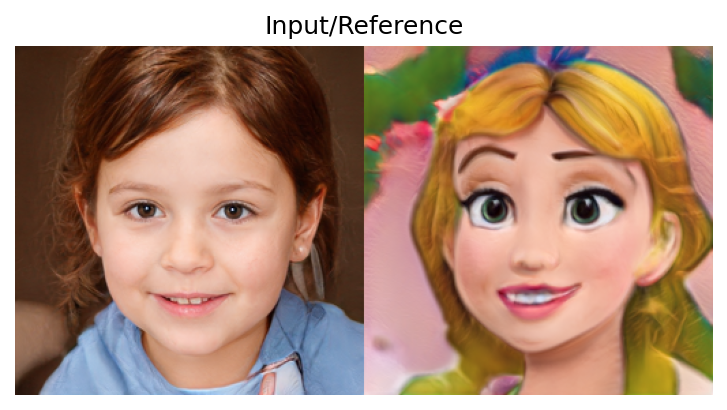

In [ ]:
truncation = .5
face_seed =  44654 
disney_seed =  686868 
    
with torch.no_grad():
    torch.manual_seed(face_seed)
    source_code = torch.randn([1, 512]).to(device)
    latent1 = generator1.get_latent(source_code, truncation=truncation, mean_latent=mean_latent1)
    source_im, _ = generator1(latent1)

    torch.manual_seed(disney_seed)
    reference_code = torch.randn([1, 512]).to(device)
    latent2 = generator2.get_latent(reference_code, truncation=truncation, mean_latent=mean_latent2)
    reference_im, _ = generator2(latent2)

    display_image(torch.cat([source_im, reference_im], -1), size=None, title='Input/Reference')

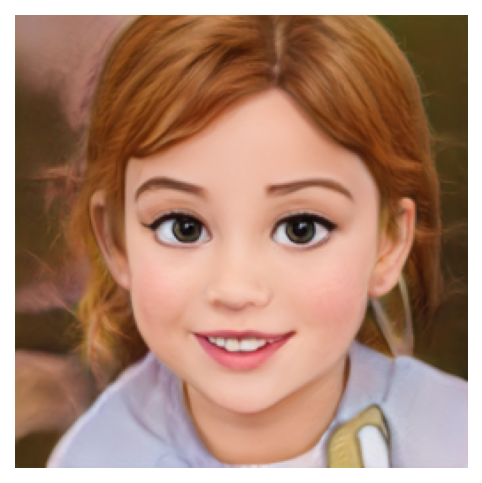

In [ ]:
num_swap =  6
alpha =  0.5

early_alpha = 0

def toonify(latent1, latent2):
    with torch.no_grad():
        noise1 = [getattr(generator1.noises, f'noise_{i}') for i in range(generator1.num_layers)]
        noise2 = [getattr(generator2.noises, f'noise_{i}') for i in range(generator2.num_layers)]

        out1 = generator1.input(latent1[0])
        out2 = generator2.input(latent2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        out1, _ = generator1.conv1(out, latent1[0], noise=noise1[0])
        out2, _ = generator2.conv1(out, latent2[0], noise=noise2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        skip1 = generator1.to_rgb1(out, latent1[1])
        skip2 = generator2.to_rgb1(out, latent2[1])
        skip = (1-early_alpha)*skip1 + early_alpha*skip2
        i = 2
        for conv1_1, conv1_2, noise1_1, noise1_2, to_rgb1, conv2_1, conv2_2, noise2_1, noise2_2, to_rgb2 in zip(
            generator1.convs[::2], generator1.convs[1::2], noise1[1::2], noise1[2::2], generator1.to_rgbs,
            generator2.convs[::2], generator2.convs[1::2], noise2[1::2], noise2[2::2], generator2.to_rgbs
        ):


            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_1(out, latent1[i], noise=noise1_1)
            out2, _ = conv2_1(out, latent2[i], noise=noise2_1)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_2(out, latent1[i], noise=noise1_2)
            out2, _ = conv2_2(out, latent2[i], noise=noise2_2)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            skip1 = to_rgb1(out, latent1[i], skip)
            skip2 = to_rgb2(out, latent2[i], skip)
            skip = (1-conv_alpha)*skip1 + conv_alpha*skip2

            i += 1

    image = skip.clamp(-1,1)
    
    return image

result = toonify(latent1, latent2)
display_image(result)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


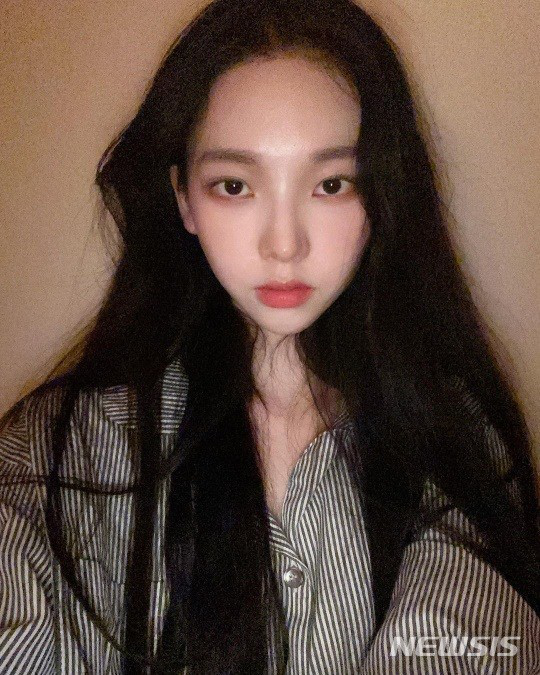

In [ ]:
from PIL import Image

Image.open('/content/drive/MyDrive/cartoon/img01.jpg')

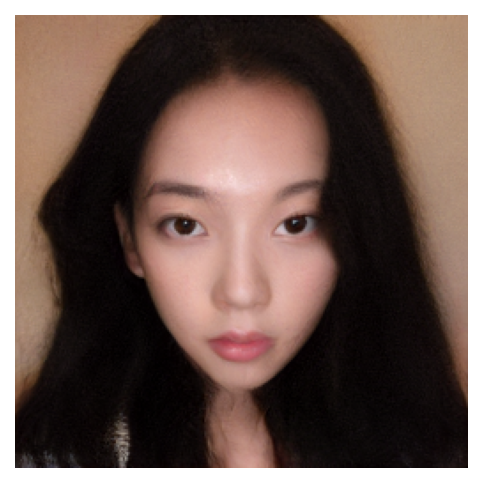

In [ ]:
latent_real = torch.load('/content/drive/MyDrive/cartoon/01.pt')['latent']
latent_real = style2list(latent_real)

source_im, _ = generator1(latent_real)

display_image(source_im)

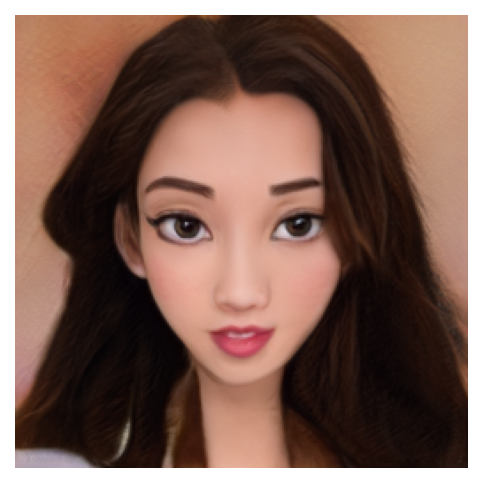

In [ ]:
result2 = toonify(latent_real, latent2)

display_image(result2)

In [ ]:
pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import os
import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import lpips
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
def gaussian_loss(v):
    # [B, 9088]
    loss = (v-gt_mean) @ gt_cov_inv @ (v-gt_mean).transpose(1,0)
    return loss.mean()

def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(0, 2, 3, 1)
        .to('cpu')
        .numpy()
    )

In [ ]:
resize = 256

transform = transforms.Compose(
    [
        transforms.Resize(resize),
        transforms.CenterCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

imgfile = '/content/drive/MyDrive/cartoon/img05_1.jpg'
imgs = []

img = transform(Image.open(imgfile).convert('RGB'))
imgs.append(img)

imgs = torch.stack(imgs, 0).to(device)

imgs.shape

torch.Size([1, 3, 256, 256])

In [ ]:
g_ema = Generator(resize, 512, 8)
ensure_checkpoint_exists('face.pt')
g_ema.load_state_dict(torch.load('face.pt')['g_ema'], strict=False)
g_ema = g_ema.to(device).eval()

In [ ]:
with torch.no_grad():
    latent_mean = g_ema.mean_latent(50000)
    latent_in = list2style(latent_mean)

# get gaussian stats
if not os.path.isfile('inversion_stats.npz'):
    with torch.no_grad():
        source = list2style(g_ema.get_latent(torch.randn([10000, 512]).cuda())).cpu().numpy()
        gt_mean = source.mean(0)
        gt_cov = np.cov(source, rowvar=False)

    # We show that style space follows gaussian distribution
    # An extension from this work https://arxiv.org/abs/2009.06529
    np.savez('inversion_stats.npz', mean=gt_mean, cov=gt_cov)

data = np.load('inversion_stats.npz')
gt_mean = torch.tensor(data['mean']).cuda().view(1,-1).float()
gt_cov_inv = torch.tensor(data['cov']).cuda()

# Only take diagonals
mask = torch.eye(*gt_cov_inv.size()).cuda()
gt_cov_inv = torch.inverse(gt_cov_inv*mask).float()

In [ ]:
step = 3000
lr = 1.0

percept = lpips.LPIPS(net='vgg', spatial=True).to(device)
latent_in.requires_grad = True

optimizer = optim.Adam([latent_in], lr=lr, betas=(0.9, 0.999))

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
min_latent = None
min_loss = 100
pbar = tqdm(range(step))
latent_path = []

for i in pbar:
    t = i / step
#     lr = get_lr(t, lr)
    if i > 0 and i % 500 == 0:
        lr *= 0.2
    latent_n = latent_in

    img_gen, _ = g_ema(style2list(latent_n))

    batch, channel, height, width = img_gen.shape

    if height > 256:
        img_gen = F.interpolate(img_gen, size=(256,256), mode='area')

    p_loss = 20*percept(img_gen, imgs).mean()
    mse_loss = 1*F.mse_loss(img_gen, imgs)
    g_loss = 1e-3*gaussian_loss(latent_n)

    loss = p_loss + mse_loss + g_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % 100 == 0:
        latent_path.append(latent_in.detach().clone())
        
    if loss.item() < min_loss:
        min_loss = loss.item()
        min_latent = latent_in.detach().clone()

    pbar.set_description(
        (
            f'loss: {loss.item():.4f}; '
            f'perceptual: {p_loss.item():.4f}; '
            f'mse: {mse_loss.item():.4f}; gaussian: {g_loss.item():.4f} lr: {lr:.4f}'
        )
    )
    
latent_path.append(latent_in.detach().clone()) # last latent vector

print(min_loss)

loss: 3.5410; perceptual: 2.4510; mse: 0.0194; gaussian: 1.0706 lr: 0.0003: 100%|██████████| 3000/3000 [06:56<00:00,  7.20it/s]

3.4362173080444336


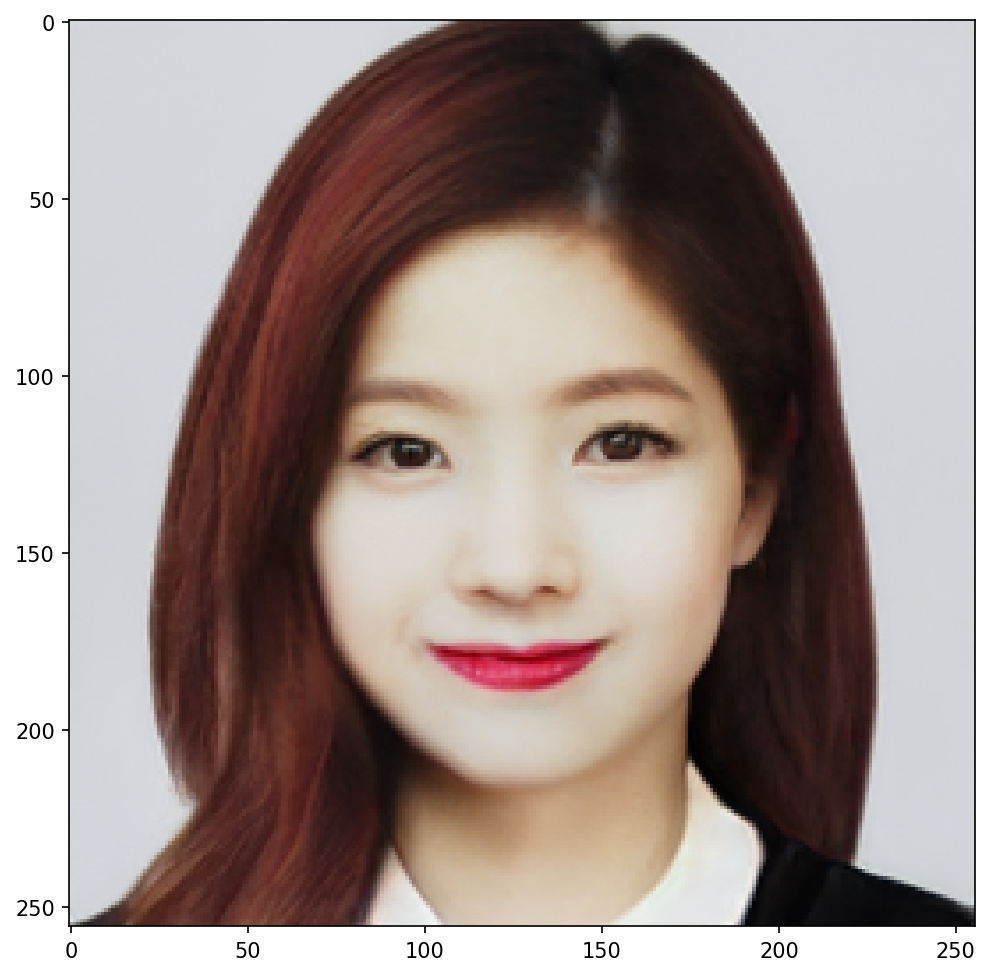

In [ ]:
img_gen, _ = g_ema(style2list(latent_path[-1]))

plt.figure(figsize=(8, 8))
plt.imshow(make_image(img_gen)[0])

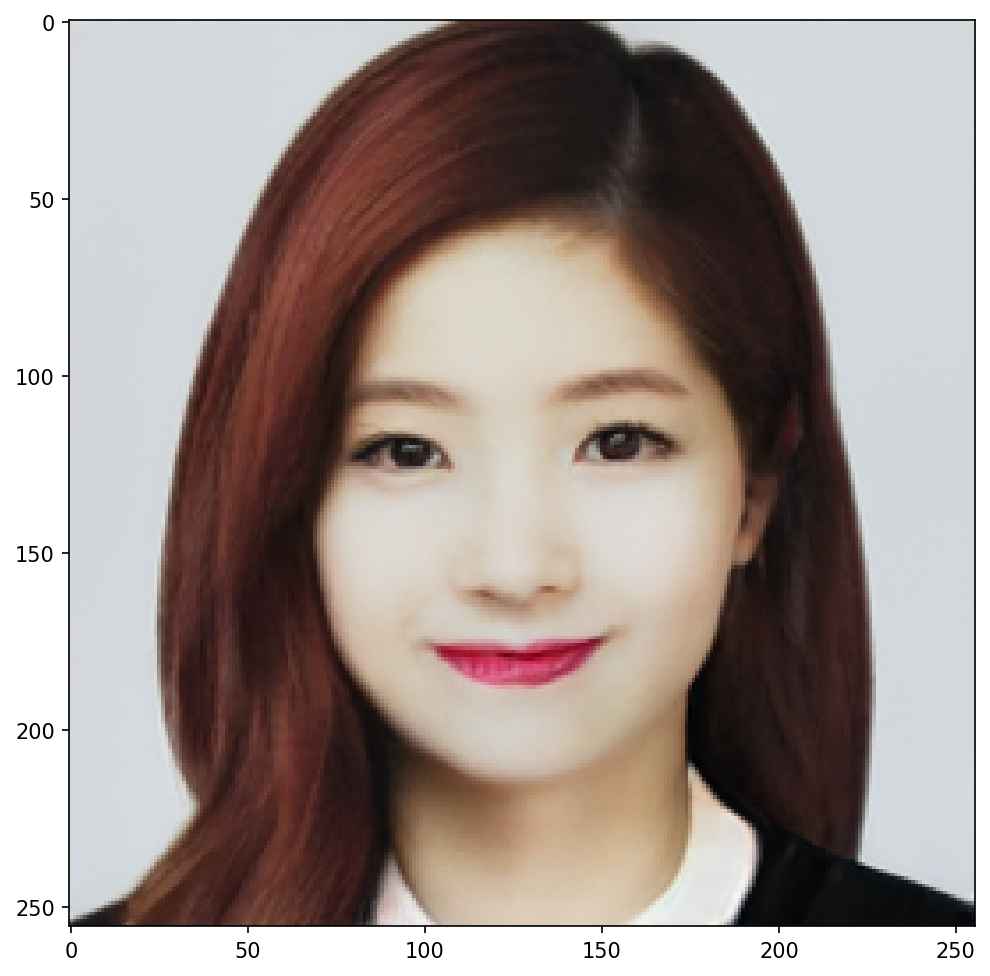

In [ ]:
img_gen, _ = g_ema(style2list(min_latent))

plt.figure(figsize=(8, 8))
plt.imshow(make_image(img_gen)[0])

In [ ]:
torch.save({'latent': min_latent}, '/content/drive/MyDrive/cartoon/05.pt')

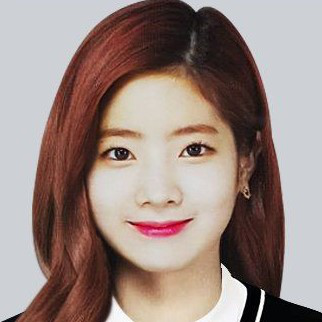

In [ ]:
from PIL import Image

Image.open('/content/drive/MyDrive/cartoon/img05_1.jpg')

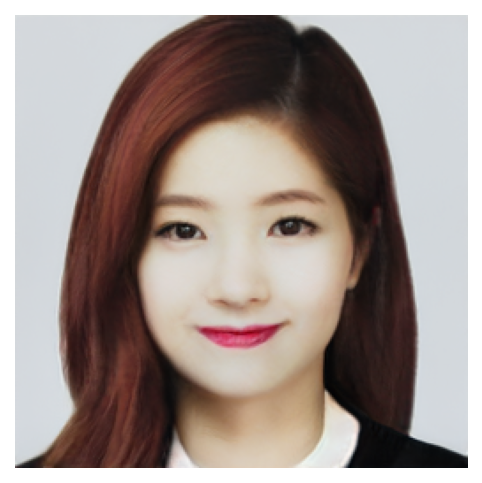

In [ ]:
latent_real = torch.load('/content/drive/MyDrive/cartoon/05.pt')['latent']
latent_real = style2list(latent_real)

source_im, _ = generator1(latent_real)

display_image(source_im)

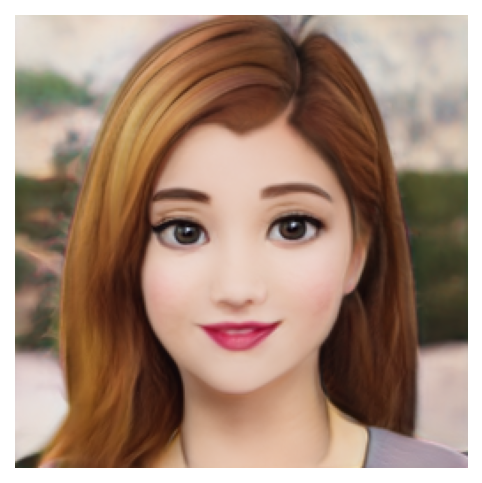

In [ ]:
result2 = toonify(latent_real, latent2)

display_image(result2)

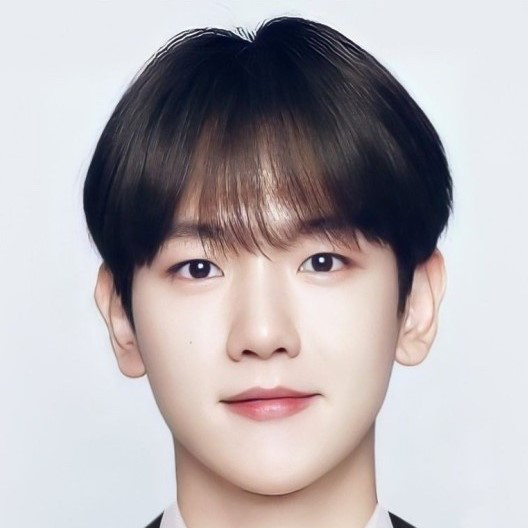

In [ ]:
from PIL import Image

Image.open('/content/drive/MyDrive/cartoon/img02_1.jpg')

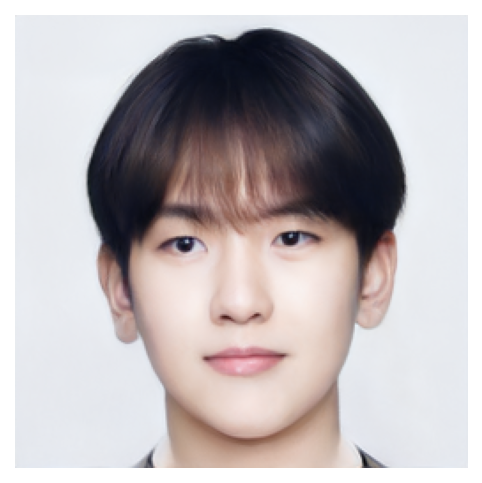

In [ ]:
latent_real = torch.load('/content/drive/MyDrive/cartoon/02.pt')['latent']
latent_real = style2list(latent_real)

source_im, _ = generator1(latent_real)

display_image(source_im)

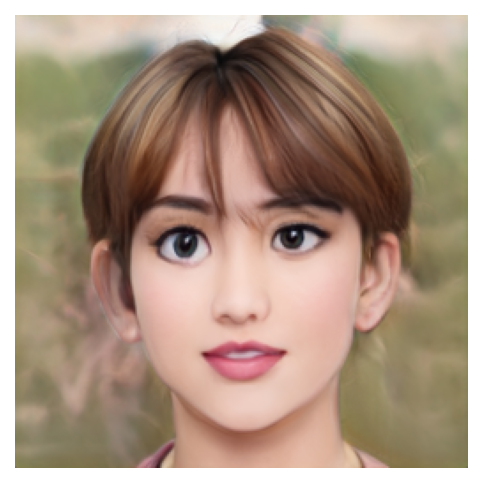

In [ ]:
result2 = toonify(latent_real, latent2)

display_image(result2)